# Partionining by Name in Milvus

#### 04-September-2024 == Partioned by Name with Milvus articles

# Goal of this Application

In this application, we will build a simple application to ingest recent Medium articles via RSS Feeds from Zilliz, Medium and Tim Spann.

### 1️⃣ Ingest and Parse RSS Feeds:
Learn to ingest data from three Medium RSS feeds and parse them with *feedparser*.   We also remove the HTML tags that are within the RSS Summary of the article

### 2️⃣ Store Data into Milvus:
Learn to store data into Milvus, an efficient vector database designed for high-speed similarity searches and AI applications.   In this step we are building a data model with scalar fields and a vector field.   This collection will be partitioned by media source.We have one large varchar field for the text of the article.   We encode the text with Sentence Transformer *all-MiniLM-L6-v2*.   

### 3️⃣ Search:
Discover how to use scalars and multiple vectors to query data stored in Milvus and re-rank the final results in this notebook.

### 4️⃣ Display Resulting Text:
Build a quick output query filtered by partition.

### 5️⃣ Examine Partitions:
We will inspect and validate the partitions that we have built in this application.  

# 🔍 Summary
By the end of this application, you’ll have a comprehensive understanding of using Milvus, data ingest object semi-structured and unstructured data, and using Open Source models to build a robust and efficient data retrieval system.   For future enhancements, we can use this information to feed a RAG or applications.


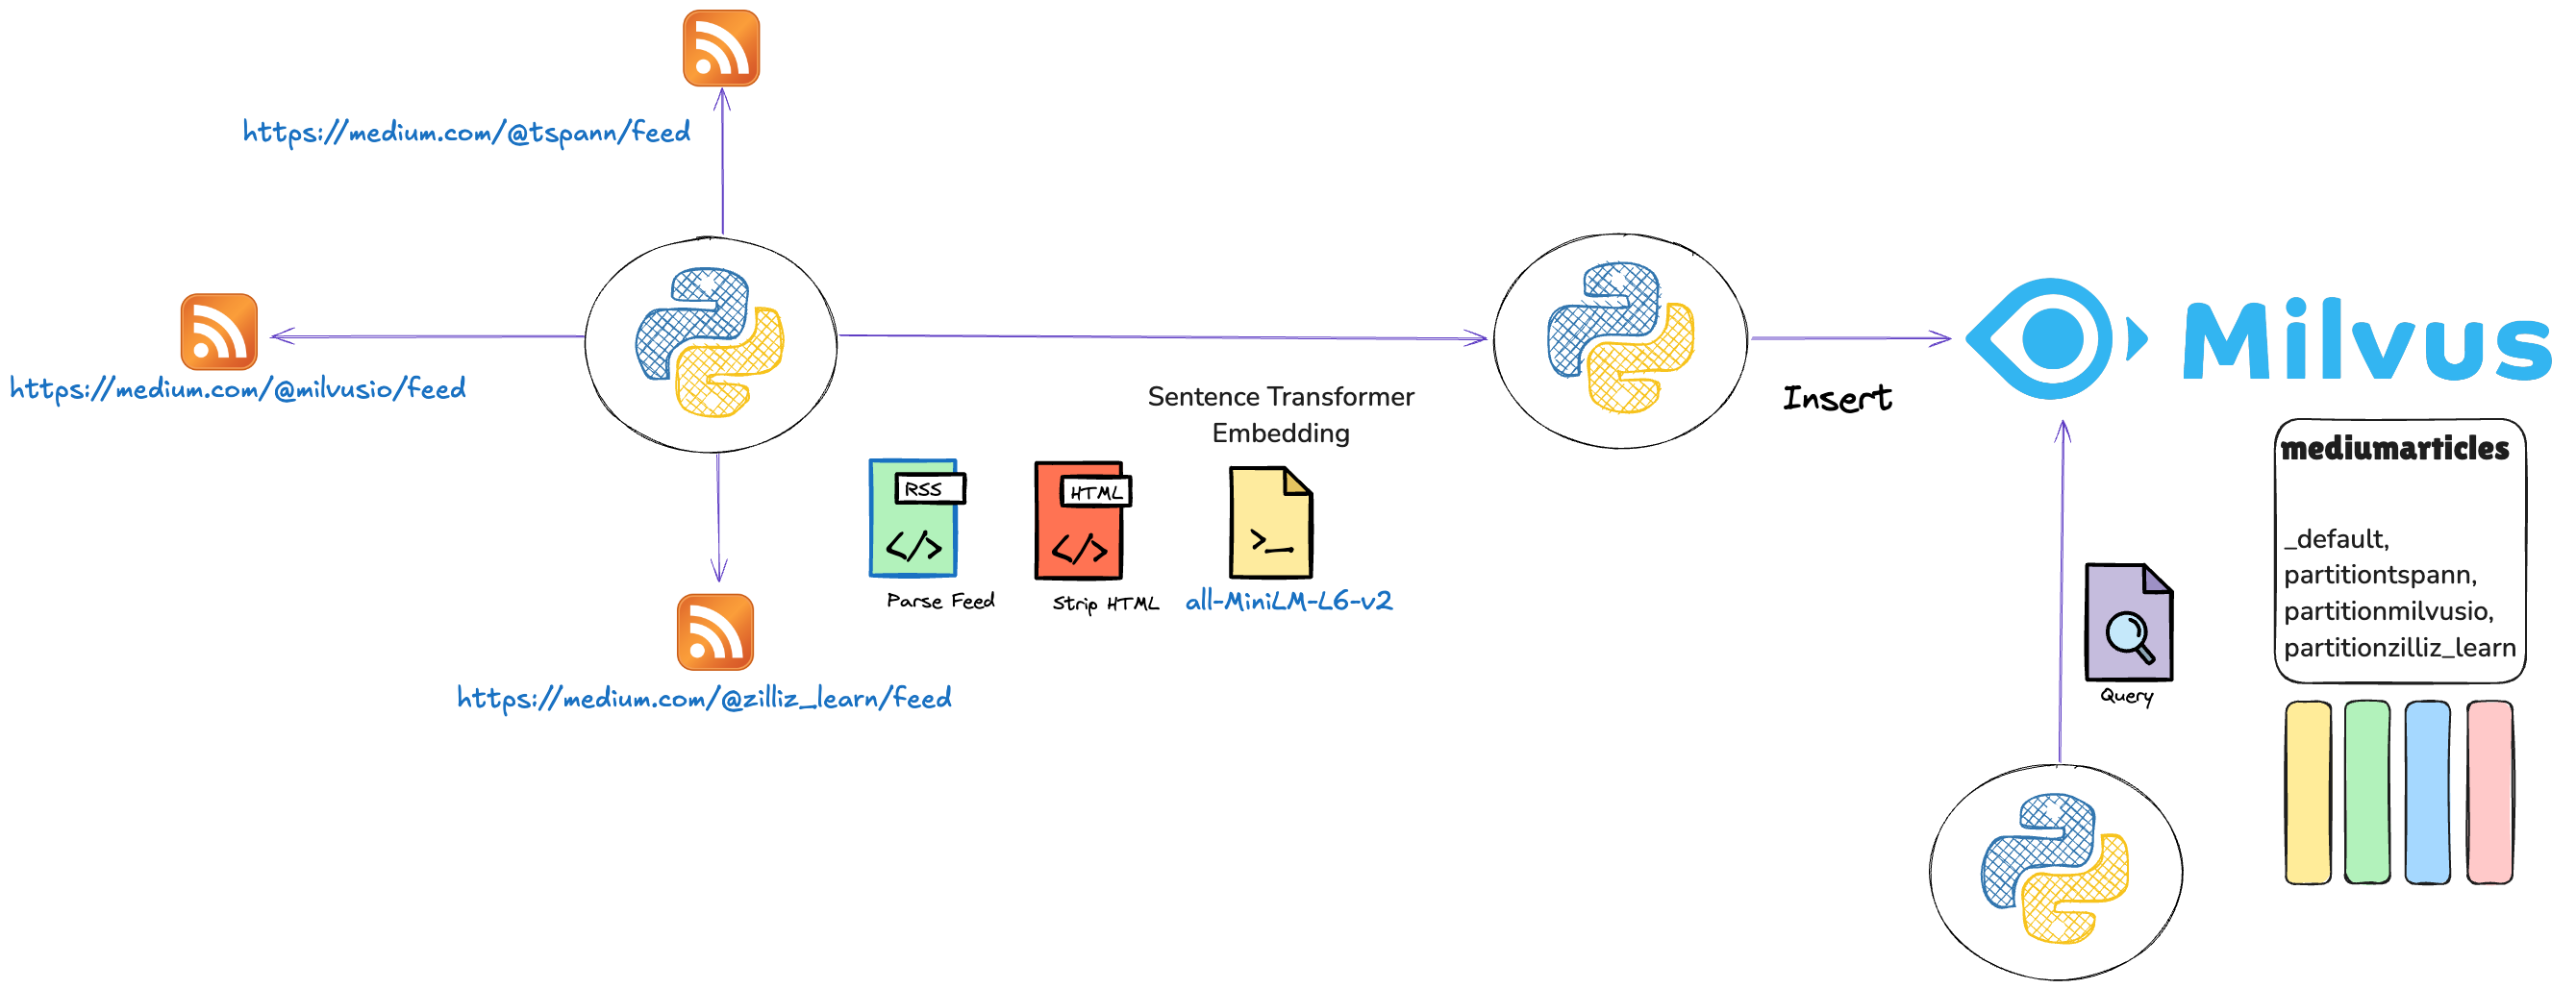


In [5]:
!pip3 install bs4 feedparser pymilvus[model]

In [10]:
import os
from pymilvus import MilvusClient
from pymilvus import (
   utility,
   FieldSchema, CollectionSchema, DataType,
   Collection, AnnSearchRequest, RRFRanker, connections, utility
)
from pymilvus import model
from pymilvus.model.dense import SentenceTransformerEmbeddingFunction

model = SentenceTransformerEmbeddingFunction('all-MiniLM-L6-v2',device='cpu' )

TSPANN_SOURCE = "tspann"
MILVUS_SOURCE = "milvusio"
ZILLIZ_SOURCE = "zilliz_learn"

COLLECTION_NAME = "mediumarticles"
TSPANN_MEDIUM_URL = "https://medium.com/@" + TSPANN_SOURCE + "/feed"
MILVUS_MEDIUM_URL = "https://medium.com/@" + MILVUS_SOURCE + "/feed"
ZILLIZ_MEDIUM_URL = "https://medium.com/@" + ZILLIZ_SOURCE + "/feed"

PARTITION_TSPANN = "partition" + TSPANN_SOURCE
PARTITION_MILVUS = "partition" + MILVUS_SOURCE
PARTITION_ZILLIZ = "partition" + ZILLIZ_SOURCE
PARTITION_FAKE   = "partitionfake"

MILVUS_URL = "http://192.168.1.153:19530" 

# Connect to Docker Server
milvus_client = MilvusClient( uri=MILVUS_URL )

In [18]:
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
import pprint

# Drop the existing collection if it exists
if milvus_client.has_collection(COLLECTION_NAME):
    print("collection exists")
else:
    ## schema
    schema = milvus_client.create_schema(auto_id=True, enable_dynamic_fields=True)
    schema.add_field(field_name="doc_author", datatype=DataType.VARCHAR,  max_length=512)
    schema.add_field(field_name="doc_source", datatype=DataType.VARCHAR,  max_length=50)
    schema.add_field(field_name="doc_tags", datatype=DataType.VARCHAR, max_length=10000)
    schema.add_field(field_name="doc_id", datatype=DataType.VARCHAR, is_primary=True, max_length=100)
    schema.add_field(field_name="doc_title", datatype=DataType.VARCHAR,  max_length=512)
    schema.add_field(field_name="doc_link", datatype=DataType.VARCHAR,  max_length=512)
    schema.add_field(field_name="doc_publisheddate", datatype=DataType.VARCHAR,  max_length=100)
    schema.add_field(field_name="doc_text", datatype=DataType.VARCHAR, max_length=65535)
    schema.add_field(field_name="doc_embedding", datatype=DataType.FLOAT_VECTOR, dim=384)

    # Create the collection
    milvus_client.create_collection(
        collection_name=COLLECTION_NAME,
        schema=schema,
        description="Medium Articles"
    )
    
    # Create index params
    index_params = [{
        "field_name": "doc_embedding",
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128}
    }]
    
    # Create index
    milvus_client.create_index(COLLECTION_NAME, index_params)

    # Create partitions
    milvus_client.create_partition(
        collection_name=COLLECTION_NAME,
        partition_name=PARTITION_TSPANN
    )     
    
    milvus_client.create_partition(
        collection_name=COLLECTION_NAME,
        partition_name=PARTITION_MILVUS
    )

    milvus_client.create_partition(
        collection_name=COLLECTION_NAME,
        partition_name=PARTITION_ZILLIZ
    )
    
    res = milvus_client.list_partitions(collection_name=COLLECTION_NAME)
    print(res)
    
    res = milvus_client.get_load_state(
        collection_name = COLLECTION_NAME
    )
    
    print(res)


['_default', 'partitiontspann', 'partitionmilvusio', 'partitionzilliz_learn']
{'state': <LoadState: NotLoad>}


In [19]:
res = milvus_client.has_partition(
    collection_name=COLLECTION_NAME,
    partition_name=PARTITION_TSPANN
)
print(res)

True


In [20]:
import feedparser
from bs4 import BeautifulSoup

# Function to remove tags
def remove_tags(html):

    # parse html content
    soup = BeautifulSoup(html, "html.parser")

    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()

    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [21]:
urls = [ TSPANN_MEDIUM_URL, MILVUS_MEDIUM_URL, ZILLIZ_MEDIUM_URL]
sources = {}
sources[ TSPANN_MEDIUM_URL ] = TSPANN_SOURCE
sources[ MILVUS_MEDIUM_URL ] = MILVUS_SOURCE
sources[ ZILLIZ_MEDIUM_URL ] = ZILLIZ_SOURCE

for url in urls:
    title = ""
    summary = ""
    link = ""
    publisheddate = ""
    author = ""
    tags = ""
    post = ""
    feed = ""
    feed = feedparser.parse(url)

    for post in feed.entries:
        try:
           #print(post)
           doc_source = str(sources[url])
           tags = ""
           for tag in post.tags:
              tags = tags + str(tag.term) + ","
           author = str(post.author)
           summary = remove_tags(str(post.summary))
           title = str(post.title)
           link = str(post.link)
           publisheddate = str(post.published)
            
           entity = {
                "doc_source": doc_source,
                "doc_author": author,
                "doc_tags": tags,
                "doc_title": title,
                "doc_link": link,
                "doc_publisheddate": publisheddate,
                "doc_text": summary,
                "doc_embedding": model(summary)
           }
           insert_result = milvus_client.insert(COLLECTION_NAME, [entity], partition_name=str("partition" + doc_source))
           print(f"Inserted document: {doc_source} {title}")
        except Exception as e: 
            print(e)

Inserted document: tspann Report: Building the Future of Startups Enhanced with Vector Databases and AI
Inserted document: tspann AIM Weekly 02 September 2024
Inserted document: tspann Utilizing Multiple Vectors and Advanced Search Data Model Design for City Data
Inserted document: tspann AIM Weekly 26 August 2024
Inserted document: tspann AIM Weekly 19-August-2024
Inserted document: tspann What’s in the Air Tonight Mr. Milvus?
Inserted document: tspann Report: 15 August 2025 — AI Camp
Inserted document: tspann Report: AI and Vectors in The Sky
Inserted document: tspann AIM Weekly for 12 August 2024
Inserted document: tspann Milvus — The Unstructured Olympics of the Mind — AI? Data?
Inserted document: milvusio Introducing PyMilvus Integration with Embedding Models
Inserted document: milvusio Introducing Milvus Lite: Start Building a GenAI Application in Seconds
Inserted document: milvusio Getting started with Milvus cluster and K8s
Inserted document: milvusio Unveiling Milvus 2.4: Mult

In [28]:
milvus_client.load_collection(COLLECTION_NAME)

res = milvus_client.get_load_state(
        collection_name = COLLECTION_NAME
)

print(res)

query_results = milvus_client.query(
    collection_name=COLLECTION_NAME,
    filter='doc_title like "%Milvus%" && doc_source == "' + str(TSPANN_SOURCE) + '"',
    output_fields=["doc_embedding", "doc_tags","doc_title","doc_link","doc_text","doc_publisheddate", "doc_source"],
    limit=3
)

lastvector = None

for result in query_results:
    lastvector = result['doc_embedding']
    print(f"{result['doc_source']} : {result['doc_title']} <{result['doc_tags']}> on {result['doc_publisheddate']} {result['doc_link']}\n")

{'state': <LoadState: Loaded>}
tspann : What’s in the Air Tonight Mr. Milvus? <open-source,generative-ai-use-cases,milvus,air-quality,vector-database,> on Fri, 16 Aug 2024 21:58:03 GMT https://medium.com/@tspann/whats-in-the-air-tonight-mr-milvus-fbd42f06e482?source=rss-13e1ea7cf9ee------2

tspann : Milvus — The Unstructured Olympics of the Mind — AI? Data? <milvus,vector-database,olympics,python,open-source,> on Fri, 09 Aug 2024 22:57:24 GMT https://medium.com/@tspann/milvus-the-unstructured-olympics-of-the-mind-ai-data-b08ee4ba8c33?source=rss-13e1ea7cf9ee------2



In [36]:
search_results = milvus_client.search(
    collection_name=COLLECTION_NAME,
    data=[lastvector],
    filter='doc_text like "%Milvus%"',
    output_fields=["doc_tags","doc_title","doc_link","doc_text","doc_publisheddate", "doc_source"],
    limit=5,
    partition_names=[PARTITION_TSPANN, PARTITION_MILVUS]
)

# -----------------------------------------------------------------------------
# Iterate through last five results and display scalars
# -----------------------------------------------------------------------------
for result in search_results:
    for hit in result[:5]:
        print( "Tags: " + hit["entity"]["doc_tags"] )
        print( "Title: " + hit["entity"]["doc_title"] )
        print( "Link: " + hit["entity"]["doc_link"] )
        print( "Source: " + hit["entity"]["doc_source"] )
        print( '-------------------------')
        

Tags: milvus,vector-database,olympics,python,open-source,
Title: Milvus — The Unstructured Olympics of the Mind — AI? Data?
Link: https://medium.com/@tspann/milvus-the-unstructured-olympics-of-the-mind-ai-data-b08ee4ba8c33?source=rss-13e1ea7cf9ee------2
Source: tspann
-------------------------
Tags: open-source,milvus,artificial-intelligence,vector-database,data-science,
Title: Introducing PyMilvus Integration with Embedding Models
Link: https://medium.com/vector-database/introducing-pymilvus-integration-with-embedding-models-a82f10d516ea?source=rss-a31576809ee1------2
Source: milvusio
-------------------------
Tags: open-source,genai,vector-database,milvus,ai,
Title: AIM Weekly for 12 August 2024
Link: https://medium.com/@tspann/aim-weekly-for-12-august-2024-e85bd19f794a?source=rss-13e1ea7cf9ee------2
Source: tspann
-------------------------
Tags: artificial-intelligence,data-science,milvus,vector-database,open-source,
Title: How to Migrate Your Data to Milvus Seamlessly: A Comprehens

In [34]:
res = milvus_client.query(
    collection_name=COLLECTION_NAME,
    output_fields=["count(*)"]
)

print(res)

data: ["{'count(*)': 30}"] 


In [27]:
res = milvus_client.get_load_state(collection_name=COLLECTION_NAME)
print(res)

res = milvus_client.get_load_state(collection_name=COLLECTION_NAME, partition_name=PARTITION_TSPANN)
print(res)

milvus_client.load_partitions(
    collection_name=COLLECTION_NAME,
    partition_names=[PARTITION_TSPANN]
)

res = milvus_client.get_load_state(collection_name=COLLECTION_NAME, partition_name=PARTITION_TSPANN)
print(res)

milvus_client.release_partitions(
    collection_name=COLLECTION_NAME,
    partition_names=[PARTITION_TSPANN]
)

res = milvus_client.get_load_state(collection_name=COLLECTION_NAME, partition_name=PARTITION_TSPANN)
print(res)

try:
    milvus_client.drop_partition( collection_name=COLLECTION_NAME, partition_name=[PARTITION_FAKE] )
except Exception as e: 
    print(e)

RPC error: [drop_partition], <ParamError: (code=1, message=`partition_name` value ['partitionfake'] is illegal)>, <Time:{'RPC start': '2024-09-05 18:03:11.584145', 'RPC error': '2024-09-05 18:03:11.584261'}>


{'state': <LoadState: Loaded>}
{'state': <LoadState: Loaded>}
{'state': <LoadState: Loaded>}
{'state': <LoadState: NotLoad>}
<ParamError: (code=1, message=`partition_name` value ['partitionfake'] is illegal)>
